<a href="https://colab.research.google.com/github/wasnaqvi/colab_notebooks/blob/main/HERMES_Extended_MetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HERMES Extended 3D MetModel Analysis

**Features implemented:**
1. Toggle intrinsic scatter (free / fixed / off)
2. Iterate over multiple MCMC seeds to probe diversity
3. Toggle log-space vs linear-space
4. Two independent leverages: $L_{\mathrm{mass}}$ and $L_{\mathrm{stellar}}$
5. Z-scores per parameter per survey (vs oracle fit)
6. WAIC model comparison (full vs no-scatter vs no-stellar)
7. All plots match HERMES `plots.py` style

In [1]:
!pip install -q numpyro jax jaxlib arviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 8.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import log_likelihood
import arviz as az
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Optional, Literal, Tuple
import warnings
warnings.filterwarnings('ignore')

numpyro.set_platform('cpu')
numpyro.set_host_device_count(1)
print('JAX devices:', jax.devices())

JAX devices: [CpuDevice(id=0)]


## 1. Load Data
Upload `hermes_synthetic_data_0.2.0.csv`.

In [3]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
raw_df = pd.read_csv(filename)
print(f'Loaded {len(raw_df)} rows, {len(raw_df.columns)} columns')
print(f'Columns: {list(raw_df.columns)}')
raw_df.head()

Saving hermes_synthetic_data_0.2.0.csv to hermes_synthetic_data_0.2.0 (1).csv
Loaded 618 rows, 8 columns
Columns: ['Planet Name', 'logM', 'log(X_H2O)', 'uncertainty_lower', 'uncertainty_upper', 'Star Metallicity', 'Star Metallicity Error Lower', 'Star Metallicity Error Upper']


,Planet Name,logM,log(X_H2O),uncertainty_lower,uncertainty_upper,Star Metallicity,Star Metallicity Error Lower,Star Metallicity Error Upper
0,WASP-43b,0.300595,-1.581438,0.2,0.2,-0.010,-0.150,0.150
1,WASP-47b,0.082785,-1.859556,0.2,0.2,0.360,-0.050,0.050
2,TOI-5704b,-1.363574,0.726944,0.2,0.2,0.428,-0.100,0.100
3,TOI-672b,-1.079603,0.989285,0.2,0.2,-0.710,-0.625,0.625
4,TOI-199b,-0.769551,-1.030190,0.2,0.2,0.220,-0.030,0.030


## 2. Configuration
Edit these toggles to control the experiment.

In [4]:
# ==================== USER CONFIGURATION ====================

# MCMC seeds to iterate over (more seeds = better diversity estimate)
MCMC_SEEDS = [321, 42]

# Survey design
SURVEY_SEED = 42          # fixed seed for survey sampling
N_GRID = [30, 50, 100]    # sample sizes
N_REPS = 5                # surveys per (class, N) combination

# MCMC settings (keep low for Colab speed; increase for production)
DRAWS = 500
TUNE = 500
TARGET_ACCEPT = 0.9
NUM_CHAINS = 1

# Toggle: intrinsic scatter  ('free', 'fixed', 'off')
SCATTER_MODE = 'free'
SCATTER_FIXED_VALUE = 0.3   # only used when SCATTER_MODE='fixed'

# Toggle: log space
# True  -> model log(X_H2O) directly  (default, same as HERMES)
# False -> model X_H2O = 10^log(X_H2O) in linear space
USE_LOG_SPACE = True

# Ground truth for z-scores (None = oracle fit on full catalog)
GROUND_TRUTH = None  # or {'alpha_p': ..., 'beta_p': ..., 'beta_s': ..., 'epsilon': ...}

# WAIC
COMPUTE_WAIC = True

n_surveys = len(N_GRID) * 4 * N_REPS
n_models = 3 + (1 if SCATTER_MODE == 'fixed' else 0)
print(f'Surveys: {n_surveys}')
print(f'Models: {n_models} variants x {len(MCMC_SEEDS)} seeds')
print(f'Total fits: {n_surveys * n_models * len(MCMC_SEEDS)}')

Surveys: 60
Models: 3 variants x 2 seeds
Total fits: 360


## 3. Survey Infrastructure
Copied from HERMES `Survey.py` (unchanged logic).

In [5]:
class Survey:
    def __init__(self, survey_id, class_label, df):
        self.survey_id = int(survey_id)
        self.class_label = str(class_label)
        self.df = df.reset_index(drop=True)

    @property
    def n(self):
        return len(self.df)

    def leverage(self, col='logM'):
        '''L = sqrt(sum_i (x_i - mean(x))^2), same as HERMES.'''
        arr = self.df[col].to_numpy(float)
        m = np.isfinite(arr)
        arr = arr[m]
        if arr.size < 2:
            return 0.0
        return float(np.sqrt(np.sum((arr - arr.mean()) ** 2)))


class SurveySampler:
    def __init__(self, raw_df, rng_seed=None):
        self.raw_df = raw_df
        self.rng = np.random.default_rng(rng_seed)
        self.mass_classes = self._build_mass_classes()

    def _build_mass_classes(self):
        df = self.raw_df
        q25, q50, q75 = df['logM'].quantile([0.25, 0.5, 0.75])
        return {
            'S1': df.copy(),
            'S2': df[df['logM'] >= q25].copy(),
            'S3': df[df['logM'] >= q50].copy(),
            'S4': df[df['logM'] >= q75].copy(),
        }

    def sample_grid(self, N_grid, n_reps_per_combo=10, class_order=None):
        if class_order is None:
            class_order = ['S1', 'S2', 'S3', 'S4']
        surveys = []
        sid = 1
        for label in class_order:
            if label not in self.mass_classes:
                continue
            subset = self.mass_classes[label]
            for N in N_grid:
                if N > len(subset):
                    continue
                for _ in range(n_reps_per_combo):
                    rs = int(self.rng.integers(0, 2**32 - 1))
                    sdf = subset.sample(n=N, replace=False, random_state=rs)
                    surveys.append(Survey(sid, label, sdf))
                    sid += 1
        return surveys

print('Survey infrastructure ready.')

Survey infrastructure ready.


## 4. Model Definitions
Three model variants for comparison, plus an optional fixed-scatter model.

| Model | Equation | Purpose |
|---|---|---|
| **B\_full** | $y = \alpha_p + \beta_p m_c + \beta_s s_c + \varepsilon$ | Current HERMES (free scatter) |
| **A\_no\_scatter** | $y = \alpha_p + \beta_p m_c + \beta_s s_c$ | Is scatter needed? |
| **C\_no\_stellar** | $y = \alpha_p + \beta_p m_c + \varepsilon$ | Is stellar met needed? |
| **D\_fixed\_scatter** | Same as B but $\varepsilon$ fixed | Prior sensitivity |

In [6]:
# ---- Model B: Full MetModel (free scatter + stellar) ----
def met_model_full(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
                   alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
                   epsilon_p_sigma):
    x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))
    x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)
    alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
    beta_s  = numpyro.sample('beta_s',  dist.Normal(1.0, beta_s_sigma))
    epsilon = numpyro.sample('epsilon',  dist.HalfNormal(epsilon_p_sigma))
    mu = alpha_p[..., None] + beta_p[..., None] * x_m_c + beta_s[..., None] * x_s_true_c
    obs_sigma = jnp.sqrt(sig_meas_p**2 + epsilon[..., None]**2)
    numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)


# ---- Model A: No scatter (epsilon = 0) ----
def met_model_no_scatter(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
                          alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
                          epsilon_p_sigma):
    x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))
    x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)
    alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
    beta_s  = numpyro.sample('beta_s',  dist.Normal(1.0, beta_s_sigma))
    numpyro.deterministic('epsilon', jnp.zeros(()))
    mu = alpha_p[..., None] + beta_p[..., None] * x_m_c + beta_s[..., None] * x_s_true_c
    numpyro.sample('y_planet', dist.Normal(mu, sig_meas_p), obs=y_planet)


# ---- Model C: No stellar term (mass + scatter only) ----
def met_model_no_stellar(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
                          alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
                          epsilon_p_sigma):
    alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
    beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
    numpyro.deterministic('beta_s', jnp.zeros(()))
    epsilon = numpyro.sample('epsilon', dist.HalfNormal(epsilon_p_sigma))
    mu = alpha_p[..., None] + beta_p[..., None] * x_m_c
    obs_sigma = jnp.sqrt(sig_meas_p**2 + epsilon[..., None]**2)
    numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)


# ---- Model D: Fixed scatter (epsilon = constant) ----
def make_met_model_fixed_scatter(fixed_value):
    fv = float(fixed_value)
    def model(*, x_m_c, x_s_obs, sig_meas_p, sig_meas_s, y_planet,
              alpha_p_mu, alpha_p_sigma, beta_p_sigma, beta_s_sigma,
              epsilon_p_sigma):
        x_s_true = numpyro.sample('x_s_true', dist.Normal(x_s_obs, sig_meas_s))
        x_s_true_c = x_s_true - jnp.mean(x_s_true, axis=-1, keepdims=True)
        alpha_p = numpyro.sample('alpha_p', dist.Normal(alpha_p_mu, alpha_p_sigma))
        beta_p  = numpyro.sample('beta_p',  dist.Normal(0.0, beta_p_sigma))
        beta_s  = numpyro.sample('beta_s',  dist.Normal(1.0, beta_s_sigma))
        numpyro.deterministic('epsilon', jnp.array(fv))
        mu = alpha_p[..., None] + beta_p[..., None] * x_m_c + beta_s[..., None] * x_s_true_c
        obs_sigma = jnp.sqrt(sig_meas_p**2 + fv**2)
        numpyro.sample('y_planet', dist.Normal(mu, obs_sigma), obs=y_planet)
    return model

print('Model definitions ready.')

Model definitions ready.


## 5. Fitting Infrastructure

In [7]:
def prepare_model_kwargs(df_in, use_log_space=True):
    '''Build the dict of JAX arrays that every model variant accepts.'''
    x_m = df_in['logM'].to_numpy(float)
    x_s_obs = df_in['Star Metallicity'].to_numpy(float)

    if use_log_space:
        yp = df_in['log(X_H2O)'].to_numpy(float)
    else:
        yp = 10.0 ** df_in['log(X_H2O)'].to_numpy(float)

    el_p = df_in['uncertainty_lower'].to_numpy(float)
    eh_p = df_in['uncertainty_upper'].to_numpy(float)
    el_s = df_in['Star Metallicity Error Lower'].to_numpy(float)
    eh_s = df_in['Star Metallicity Error Upper'].to_numpy(float)

    sig_p = np.clip(0.5 * (np.abs(el_p) + np.abs(eh_p)), 1e-6, None)
    sig_s = np.clip(0.5 * (np.abs(el_s) + np.abs(eh_s)), 1e-6, None)

    if not use_log_space:
        sig_p = np.abs(yp) * sig_p * np.log(10)

    m = (np.isfinite(x_m) & np.isfinite(x_s_obs) & np.isfinite(yp)
         & np.isfinite(sig_p) & np.isfinite(sig_s))
    x_m, x_s_obs, yp, sig_p, sig_s = x_m[m], x_s_obs[m], yp[m], sig_p[m], sig_s[m]

    x_m_c = x_m - float(x_m.mean())

    span_xm = max(float(np.ptp(x_m_c)), 1e-3)
    span_xs = max(float(np.ptp(x_s_obs - x_s_obs.mean())), 1e-3)
    span_yp = max(float(np.ptp(yp)), 1e-3)
    yp_sd = max(float(np.std(yp, ddof=1)) if len(yp) > 1 else 1.0, 1e-3)

    return dict(
        x_m_c       = jnp.array(x_m_c,   dtype=jnp.float32),
        x_s_obs     = jnp.array(x_s_obs,  dtype=jnp.float32),
        sig_meas_p  = jnp.array(sig_p,    dtype=jnp.float32),
        sig_meas_s  = jnp.array(sig_s,    dtype=jnp.float32),
        y_planet    = jnp.array(yp,       dtype=jnp.float32),
        alpha_p_mu     = float(yp.mean()),
        alpha_p_sigma  = max(float(yp_sd / np.sqrt(len(yp))), 1e-3),
        beta_p_sigma   = max(float(span_yp / span_xm), 1e-3),
        beta_s_sigma   = max(float(span_yp / span_xs), 1e-3),
        epsilon_p_sigma = max(float(yp_sd), 1e-3),
    )


def fit_model(model_fn, mkw, seed, draws, tune, ta, nchains=1, do_ll=False):
    rng_key = jax.random.PRNGKey(int(seed))
    kernel = NUTS(model_fn, target_accept_prob=float(ta))
    mcmc = MCMC(kernel, num_warmup=int(tune), num_samples=int(draws),
                num_chains=int(nchains), progress_bar=False)
    mcmc.run(rng_key, **mkw)
    if do_ll:
        post = mcmc.get_samples(group_by_chain=True)
        ll = log_likelihood(model_fn, post, **mkw)
        return az.from_numpyro(mcmc, log_likelihood=ll)
    return az.from_numpyro(mcmc)


def extract_summary(idata):
    row = {}
    for param in ['alpha_p', 'beta_p', 'beta_s', 'epsilon']:
        if param in idata.posterior:
            s = np.asarray(idata.posterior[param]).reshape(-1)
            row[f'{param}_mean'] = float(s.mean())
            row[f'{param}_sd']   = float(s.std(ddof=1)) if s.size > 1 else 0.0
            lo, hi = np.quantile(s, [0.16, 0.84])
            row[f'{param}_hdi16'] = float(lo)
            row[f'{param}_hdi84'] = float(hi)
    return row

print('Fitting infrastructure ready.')

Fitting infrastructure ready.


## 6. Run Experiments
Build surveys once, then fit every (model, seed) combination.

In [8]:
# Build surveys ONCE
sampler = SurveySampler(raw_df, rng_seed=SURVEY_SEED)
surveys = sampler.sample_grid(N_GRID, n_reps_per_combo=N_REPS)
print(f'Built {len(surveys)} surveys')

# Model variants
MODEL_VARIANTS = [
    (met_model_full,       'B_full'),
    (met_model_no_scatter, 'A_no_scatter'),
    (met_model_no_stellar, 'C_no_stellar'),
]
if SCATTER_MODE == 'fixed':
    MODEL_VARIANTS.append(
        (make_met_model_fixed_scatter(SCATTER_FIXED_VALUE), 'D_fixed_scatter')
    )

PRIMARY = {'free': 'B_full', 'off': 'A_no_scatter', 'fixed': 'D_fixed_scatter'}[SCATTER_MODE]

# Run
all_rows = []
total = len(surveys) * len(MODEL_VARIANTS) * len(MCMC_SEEDS)
count = 0

for model_fn, mname in MODEL_VARIANTS:
    print(f'\n--- {mname} ---')
    for mseed in MCMC_SEEDS:
        rng = np.random.default_rng(mseed)
        for survey in surveys:
            count += 1
            if count % 30 == 0 or count == total:
                print(f'  [{count}/{total}]', flush=True)
            rs = int(rng.integers(0, 2**32 - 1))
            mkw = prepare_model_kwargs(survey.df, use_log_space=USE_LOG_SPACE)
            idata = fit_model(model_fn, mkw, rs,
                              draws=DRAWS, tune=TUNE, ta=TARGET_ACCEPT,
                              nchains=NUM_CHAINS, do_ll=COMPUTE_WAIC)
            row = extract_summary(idata)
            row['model']       = mname
            row['seed']        = mseed
            row['survey_id']   = survey.survey_id
            row['class_label'] = survey.class_label
            row['N']           = survey.n
            row['L_mass']      = survey.leverage('logM')
            row['L_stellar']   = survey.leverage('Star Metallicity')

            if COMPUTE_WAIC:
                try:
                    w = az.waic(idata)
                    row['waic']    = float(w.elpd_waic)
                    row['waic_se'] = float(w.se)
                except Exception:
                    row['waic']    = np.nan
                    row['waic_se'] = np.nan

            all_rows.append(row)

df_results = pd.DataFrame(all_rows)
print(f'\nDone! {len(df_results)} rows.')
df_results.to_csv('hermes_extended_results.csv', index=False)
print('Saved hermes_extended_results.csv')

Built 60 surveys

--- B_full ---
  [30/360]
  [60/360]
  [90/360]
  [120/360]

--- A_no_scatter ---
  [150/360]
  [180/360]
  [210/360]
  [240/360]

--- C_no_stellar ---
  [270/360]
  [300/360]
  [330/360]
  [360/360]

Done! 360 rows.
Saved hermes_extended_results.csv


## 7. Oracle Fit & Z-Scores

Z-score: $z_\theta^{(k)} = \frac{\hat\theta^{(k)} - \theta_{\rm ref}}{\sigma_\theta^{(k)}}$

If the model is well-calibrated, z-scores across surveys should be ~ $\mathcal{N}(0,1)$.

In [9]:
if GROUND_TRUTH is None:
    print('Fitting oracle on full catalog ...')
    oracle_mkw = prepare_model_kwargs(raw_df, use_log_space=USE_LOG_SPACE)
    oracle_idata = fit_model(met_model_full, oracle_mkw, seed=0,
                             draws=DRAWS*2, tune=TUNE*2, ta=TARGET_ACCEPT,
                             nchains=NUM_CHAINS, do_ll=False)
    REFERENCE = {}
    for p in ['alpha_p', 'beta_p', 'beta_s', 'epsilon']:
        REFERENCE[p] = float(np.asarray(oracle_idata.posterior[p]).mean())
    print('Oracle reference:', REFERENCE)
else:
    REFERENCE = GROUND_TRUTH
    print('Using provided ground truth:', REFERENCE)

for p in ['alpha_p', 'beta_p', 'beta_s', 'epsilon']:
    mc = f'{p}_mean'
    sc = f'{p}_sd'
    if mc in df_results.columns and sc in df_results.columns:
        df_results[f'z_{p}'] = (
            (df_results[mc] - REFERENCE[p]) / df_results[sc].clip(lower=1e-10)
        )

print('\nZ-score summary (primary model, first seed):')
mask = (df_results['model'] == PRIMARY) & (df_results['seed'] == MCMC_SEEDS[0])
z_cols = [c for c in df_results.columns if c.startswith('z_')]
display(df_results.loc[mask, z_cols].describe().round(3))

Fitting oracle on full catalog ...
Oracle reference: {'alpha_p': -0.3158727288246155, 'beta_p': -1.134774923324585, 'beta_s': 0.05986960232257843, 'epsilon': 0.49396830797195435}

Z-score summary (primary model, first seed):


,z_alpha_p,z_beta_p,z_beta_s,z_epsilon
count,60.000,60.000,60.000,60.000
mean,-11.579,0.367,0.219,-0.017
std,9.302,1.134,1.077,0.822
min,-32.358,-2.742,-2.336,-2.376
25%,-16.865,-0.448,-0.677,-0.541
50%,-11.256,0.405,0.401,0.030
75%,-5.004,1.139,1.029,0.496
max,2.354,2.741,2.137,1.780


## 8. WAIC Model Comparison

$\Delta$WAIC$_{\rm scatter}$ = elpd(full) $-$ elpd(no scatter) $\rightarrow$ positive = scatter helps

$\Delta$WAIC$_{\rm stellar}$ = elpd(full) $-$ elpd(no stellar) $\rightarrow$ positive = stellar met helps

In [10]:
waic_wide = None
if COMPUTE_WAIC and 'waic' in df_results.columns:
    piv = df_results.pivot_table(
        index=['survey_id', 'seed', 'class_label', 'N', 'L_mass', 'L_stellar'],
        columns='model', values='waic',
    ).reset_index()

    waic_wide = piv.copy()
    if 'B_full' in piv.columns and 'A_no_scatter' in piv.columns:
        waic_wide['delta_waic_scatter'] = piv['B_full'] - piv['A_no_scatter']
    if 'B_full' in piv.columns and 'C_no_stellar' in piv.columns:
        waic_wide['delta_waic_stellar'] = piv['B_full'] - piv['C_no_stellar']

    for col in ['delta_waic_scatter', 'delta_waic_stellar']:
        if col in waic_wide.columns:
            v = waic_wide[col].dropna()
            print(f'{col}: mean={v.mean():.3f}  median={v.median():.3f}  frac>0={((v>0).mean()):.1%}')
else:
    print('WAIC not available.')

delta_waic_scatter: mean=66.350  median=55.644  frac>0=96.7%
delta_waic_stellar: mean=-0.339  median=-0.517  frac>0=23.3%


## 9. Results Summary

In [11]:
df_prim = df_results[df_results['model'] == PRIMARY].copy()
print(f'Primary model: {PRIMARY}')
print(f'\nSurveys per (class, N):')
display(df_prim.groupby(['class_label', 'N']).size().unstack(fill_value=0))

sd_cols = [c for c in ['alpha_p_sd','beta_p_sd','beta_s_sd','epsilon_sd'] if c in df_prim.columns]
print('\nMean posterior SD by class:')
display(df_prim.groupby('class_label')[sd_cols].mean().round(4))

Primary model: B_full

Surveys per (class, N):


N,30,50,100
class_label,,,
S1,10,10,10
S2,10,10,10
S3,10,10,10
S4,10,10,10



Mean posterior SD by class:


,alpha_p_sd,beta_p_sd,beta_s_sd,epsilon_sd
class_label,,,,
S1,0.0704,0.1005,0.4552,0.0642
S2,0.0638,0.1408,0.4763,0.0628
S3,0.0566,0.2283,0.4466,0.0603
S4,0.0544,0.2546,0.4838,0.0602


## 10. Plots
All plots use the HERMES `plots.py` style.

In [12]:
# ---- HERMES plot style ----
plt.rcParams.update({
    'figure.dpi': 130, 'savefig.dpi': 300, 'font.size': 11,
    'axes.titlesize': 12, 'axes.labelsize': 11,
    'axes.spines.top': False, 'axes.spines.right': False,
    'axes.linewidth': 1.0,
    'xtick.direction': 'out', 'ytick.direction': 'out',
    'xtick.major.size': 4,   'ytick.major.size': 4,
})

CLS_ORD = ['S1', 'S2', 'S3', 'S4']
CLS_CLR = {'S1': 'C0', 'S2': 'C1', 'S3': 'C2', 'S4': 'C3'}


def _pl_fit(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    lx, ly = np.log(x[m]), np.log(y[m])
    A = np.vstack([np.ones_like(lx), lx]).T
    b = np.linalg.lstsq(A, ly, rcond=None)[0]
    return float(np.exp(b[0])), float(b[1])


def _pl_band(x, y, xg, z=1.0):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    lx, ly = np.log(x[m]), np.log(y[m])
    A = np.vstack([np.ones_like(lx), lx]).T
    b, *_ = np.linalg.lstsq(A, ly, rcond=None)
    lxg = np.log(np.asarray(xg, float))
    mu = b[0] + b[1] * lxg
    r = ly - (A @ b)
    dof = max(len(ly) - 2, 1)
    s2 = float(np.dot(r, r) / dof)
    Ai = np.linalg.inv(A.T @ A)
    Ag = np.vstack([np.ones_like(lxg), lxg]).T
    v = np.einsum('ij,jk,ik->i', Ag, Ai, Ag) * s2
    se = np.sqrt(np.maximum(v, 0.0))
    return np.exp(mu), np.exp(mu - z * se), np.exp(mu + z * se)


def _lin_fit(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    X = np.vstack([np.ones_like(x[m]), x[m]]).T
    return np.linalg.lstsq(X, y[m], rcond=None)[0]


def scatter_fits(ax, x, y, labels, ylabel_tex, xlabel_tex):
    '''Scatter by class + power-law + linear overlays (HERMES style).'''
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    for cls in CLS_ORD:
        cm = (labels == cls)
        if not cm.any():
            continue
        ax.scatter(x[cm], y[cm], s=18, alpha=0.9, color=CLS_CLR.get(cls, 'k'), label=cls)
    ax.set_xlabel(xlabel_tex)
    ax.set_ylabel(ylabel_tex)
    ax.minorticks_on()
    xf, yf = x[m], y[m]
    if xf.size < 2:
        return
    xg = np.linspace(xf.min() * 0.98, xf.max() * 1.02, 200)
    yh, lo, hi = _pl_band(xf, yf, xg)
    ax.fill_between(xg, lo, hi, alpha=0.15, linewidth=0)
    ax.plot(xg, yh, ls='--', lw=1.2)
    try:
        c, sl = _lin_fit(xf, yf)
        ax.plot(xg, c + sl * xg, ls='-.', lw=1.0)
    except Exception:
        pass
    a, b = _pl_fit(xf, yf)
    xr, yr = ax.get_xlim(), ax.get_ylim()
    ann = ylabel_tex + r' $\propto L^{' + f'{b:.2f}' + r'}$'
    ax.text(xr[0] + 0.55*(xr[1]-xr[0]), yr[0] + 0.86*(yr[1]-yr[0]), ann, fontsize=8)


def add_legend(ax, sub):
    hs, ls = [], []
    for cls in CLS_ORD:
        if (sub['class_label'] == cls).any():
            hs.append(plt.Line2D([], [], ls='none', marker='o', ms=5, color=CLS_CLR.get(cls,'k')))
            ls.append(cls)
    if hs:
        ax.legend(hs, ls, title='class', fontsize=8, title_fontsize=9, frameon=False, loc='best')

print('Plot utilities ready.')

Plot utilities ready.


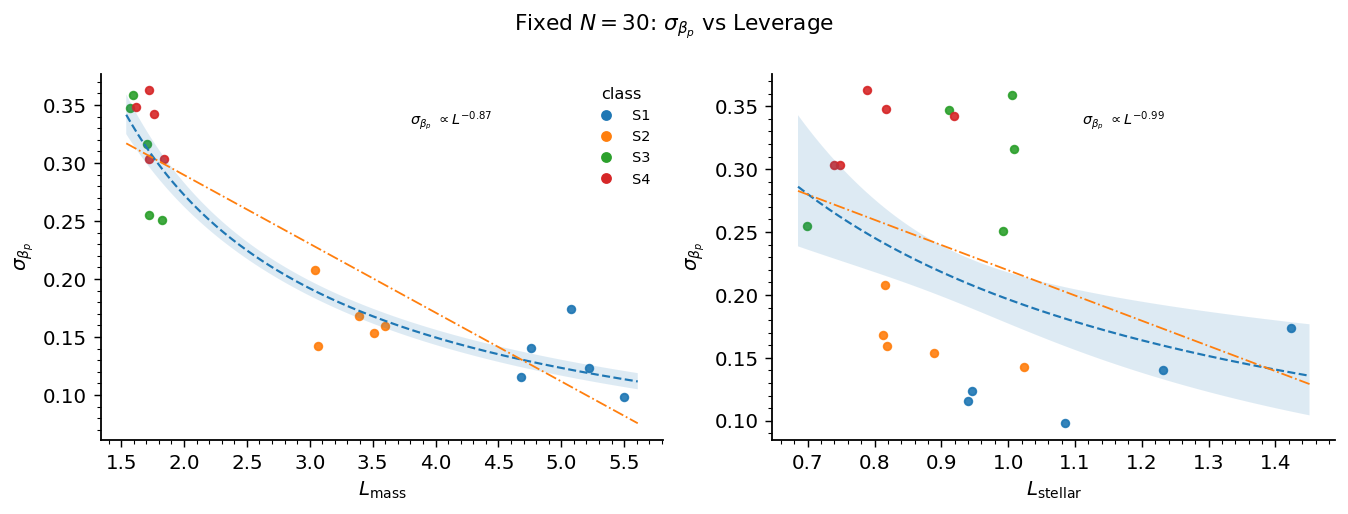

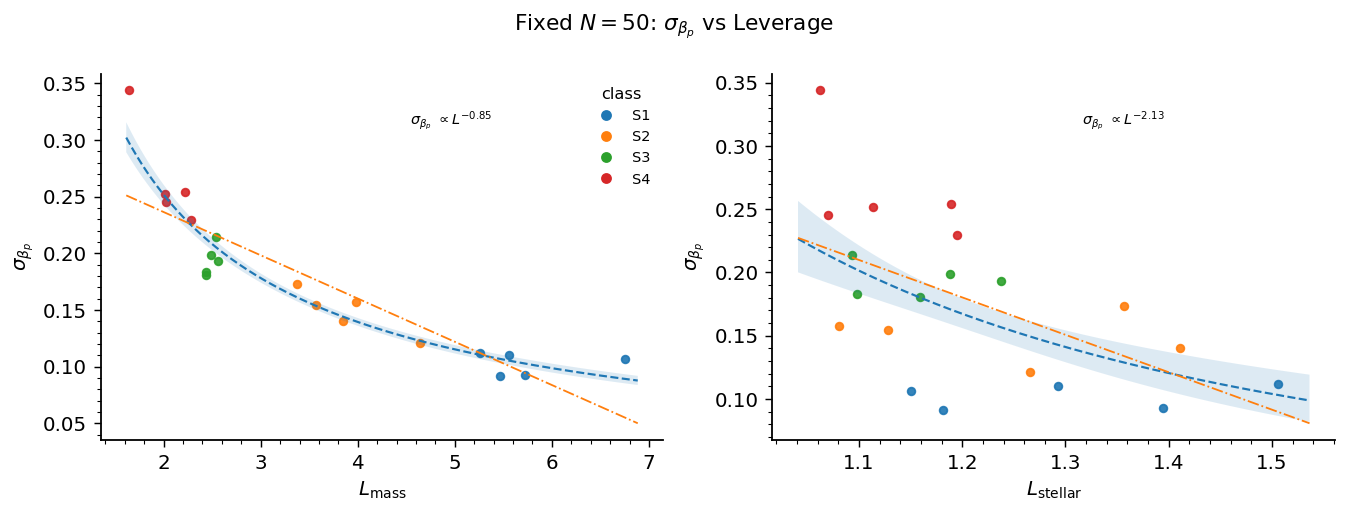

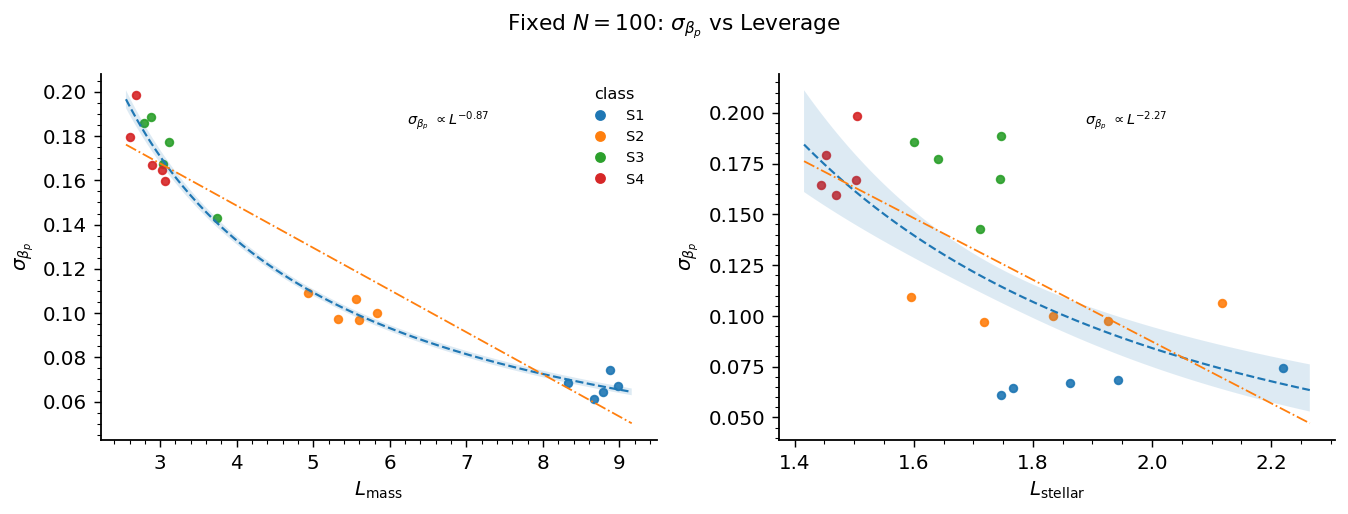

In [13]:
# sigma(beta_p) vs L_mass AND L_stellar  (fixed-N panels)
df_pl = df_results[(df_results['model'] == PRIMARY) &
                   (df_results['seed'] == MCMC_SEEDS[0])].copy()

for N0 in sorted(df_pl['N'].unique()):
    sub = df_pl[df_pl['N'] == N0]
    if len(sub) < 3:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
    fig.suptitle(rf'Fixed $N={N0}$: $\sigma_{{\beta_p}}$ vs Leverage', fontsize=12)
    labels = sub['class_label'].to_numpy(str)
    scatter_fits(axes[0], sub['L_mass'].values, sub['beta_p_sd'].values,
                 labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{mass}}$')
    scatter_fits(axes[1], sub['L_stellar'].values, sub['beta_p_sd'].values,
                 labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{stellar}}$')
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.show()

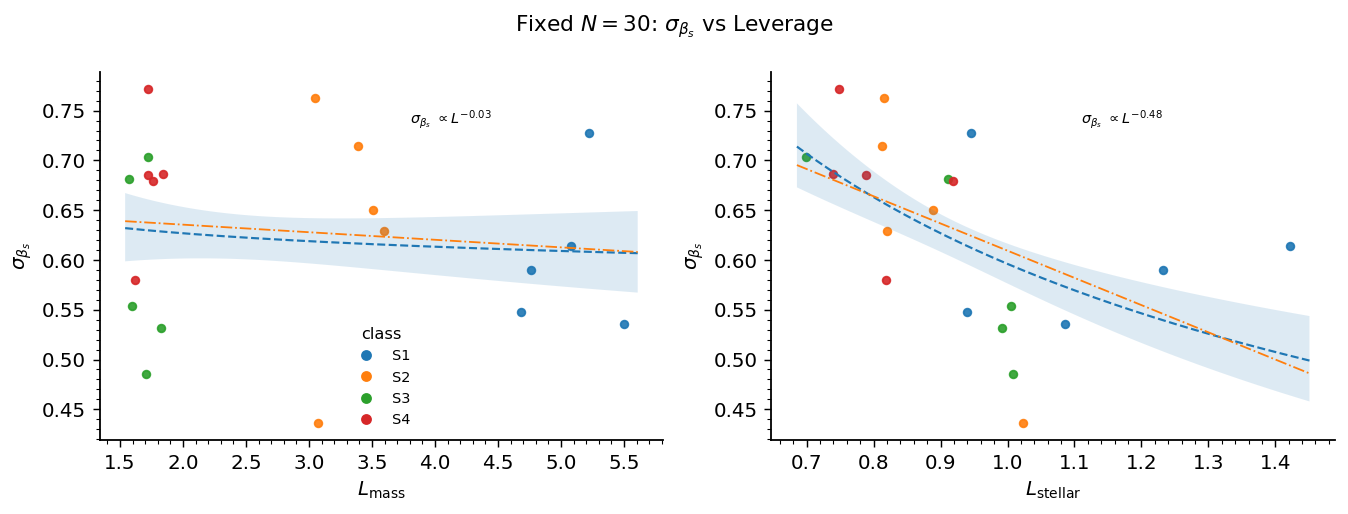

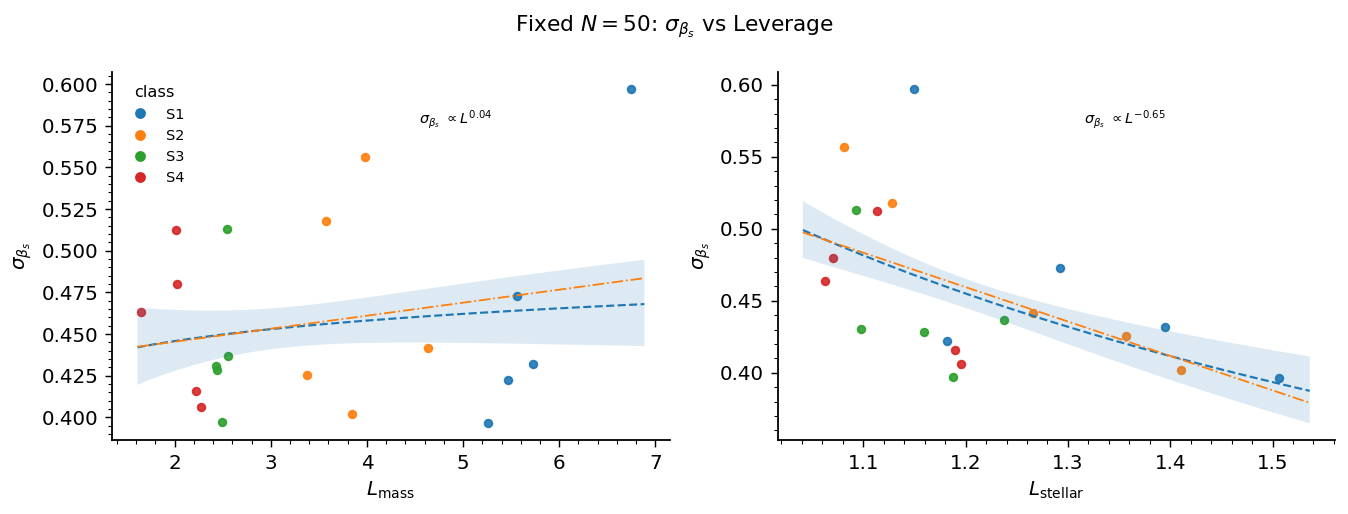

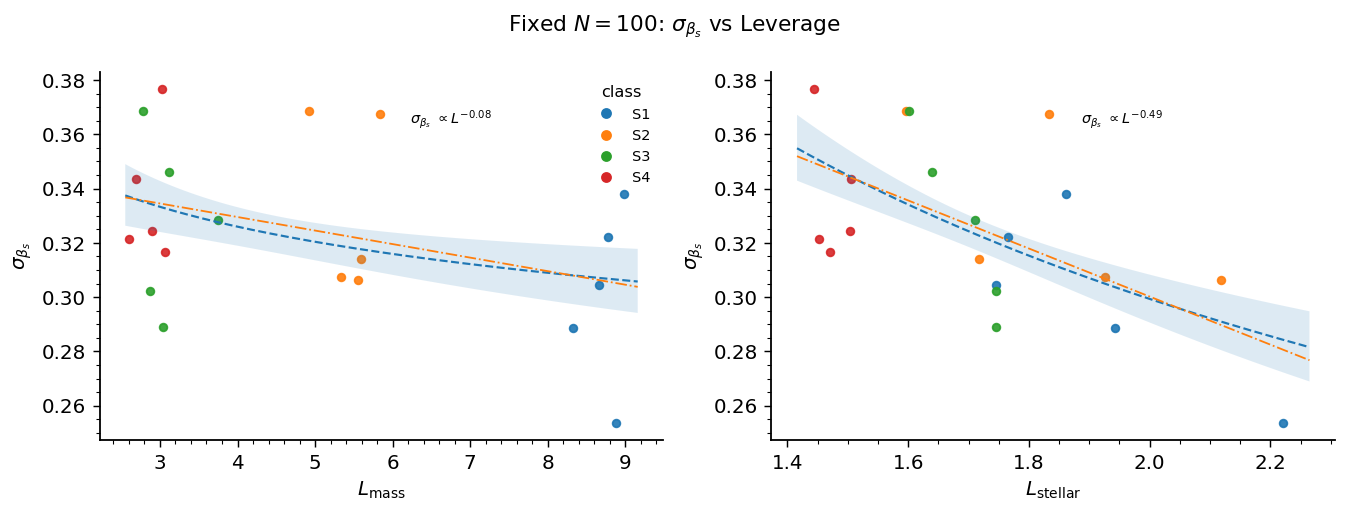

In [14]:
# sigma(beta_s) vs L_mass AND L_stellar  (fixed-N panels)
for N0 in sorted(df_pl['N'].unique()):
    sub = df_pl[df_pl['N'] == N0]
    if len(sub) < 3 or 'beta_s_sd' not in sub.columns:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
    fig.suptitle(rf'Fixed $N={N0}$: $\sigma_{{\beta_s}}$ vs Leverage', fontsize=12)
    labels = sub['class_label'].to_numpy(str)
    scatter_fits(axes[0], sub['L_mass'].values, sub['beta_s_sd'].values,
                 labels, r'$\sigma_{\beta_s}$', r'$L_{\mathrm{mass}}$')
    scatter_fits(axes[1], sub['L_stellar'].values, sub['beta_s_sd'].values,
                 labels, r'$\sigma_{\beta_s}$', r'$L_{\mathrm{stellar}}$')
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.show()

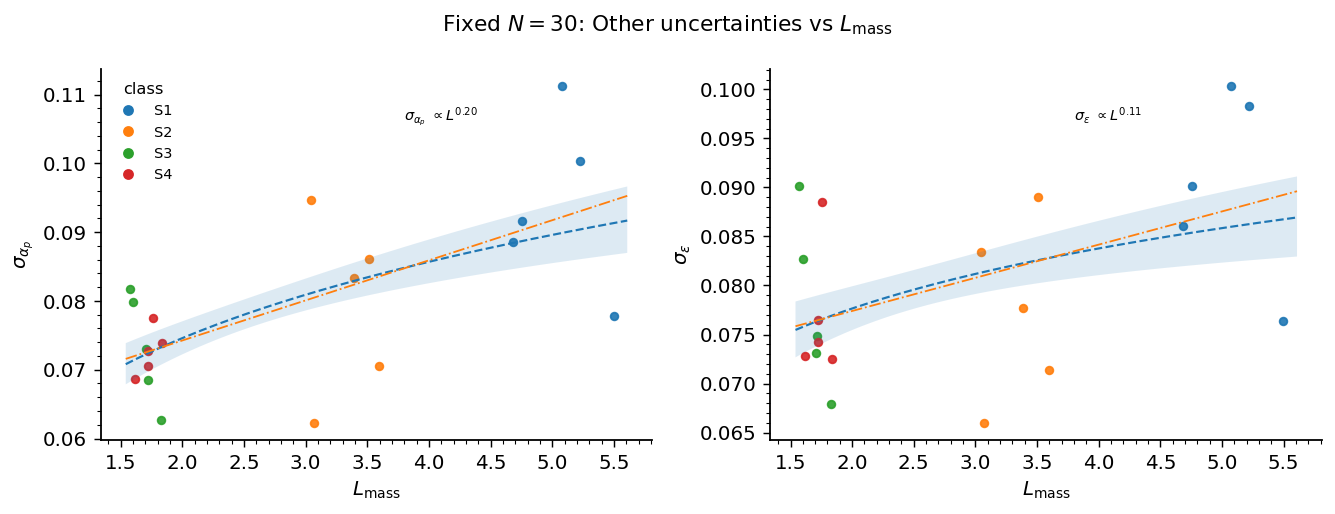

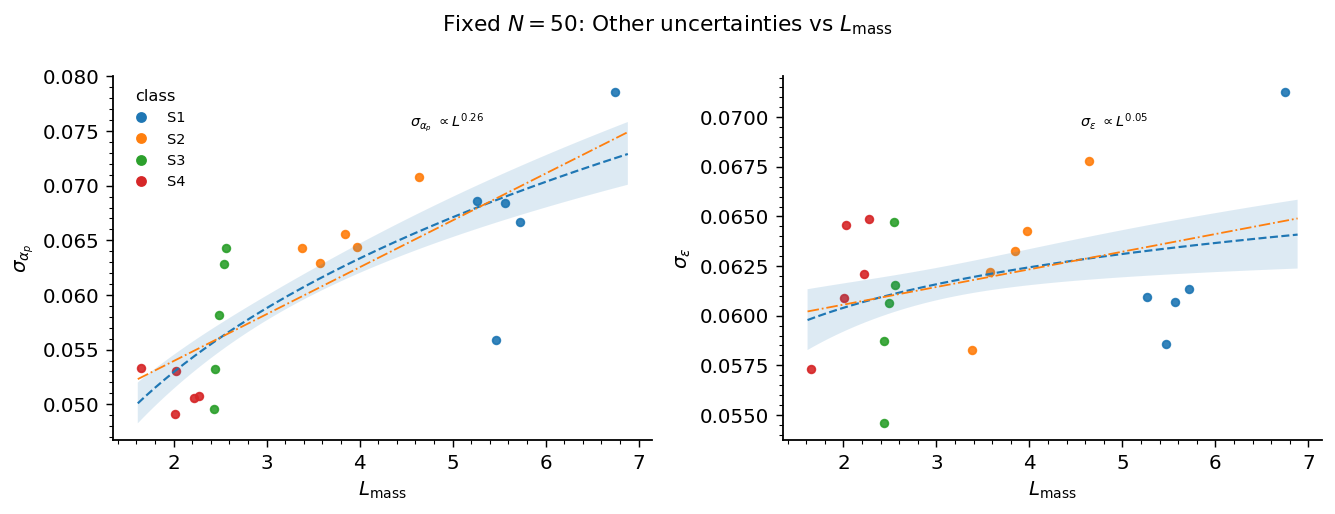

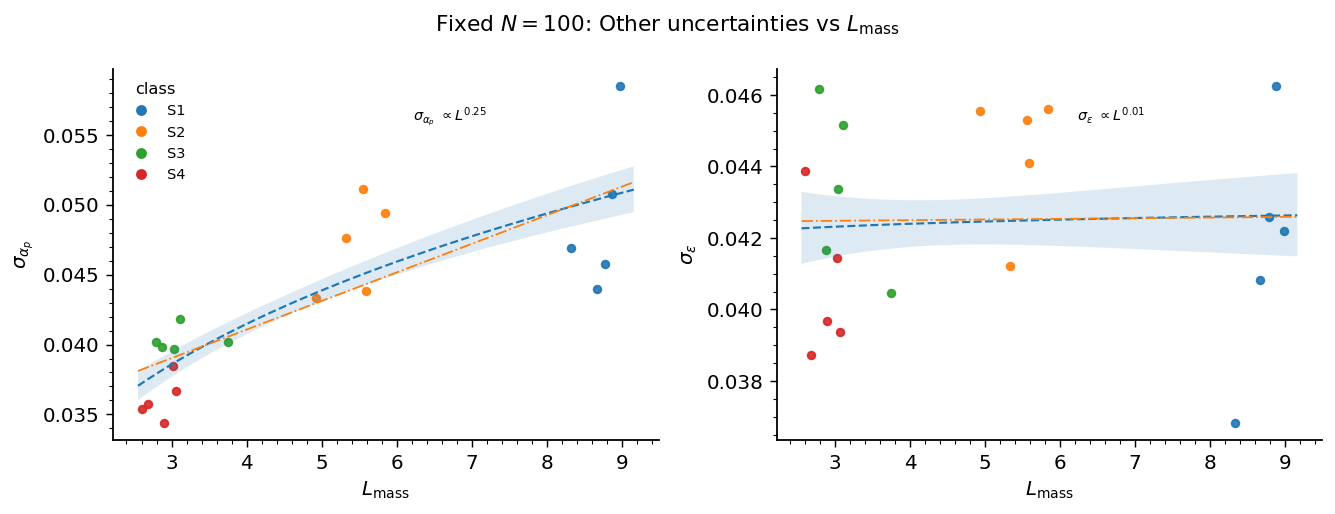

In [15]:
# sigma(alpha_p) and sigma(epsilon) vs L_mass  (fixed-N panels)
for N0 in sorted(df_pl['N'].unique()):
    sub = df_pl[df_pl['N'] == N0]
    if len(sub) < 3:
        continue
    panels = []
    if 'alpha_p_sd' in sub.columns:
        panels.append(('alpha_p_sd', r'$\sigma_{\alpha_p}$'))
    if 'epsilon_sd' in sub.columns:
        panels.append(('epsilon_sd', r'$\sigma_{\varepsilon}$'))
    if not panels:
        continue
    fig, axes = plt.subplots(1, len(panels), figsize=(5.2*len(panels), 4))
    if len(panels) == 1:
        axes = [axes]
    fig.suptitle(rf'Fixed $N={N0}$: Other uncertainties vs $L_{{\mathrm{{mass}}}}$', fontsize=12)
    labels = sub['class_label'].to_numpy(str)
    for ax, (col, ylabel) in zip(axes, panels):
        scatter_fits(ax, sub['L_mass'].values, sub[col].values,
                     labels, ylabel, r'$L_{\mathrm{mass}}$')
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.show()

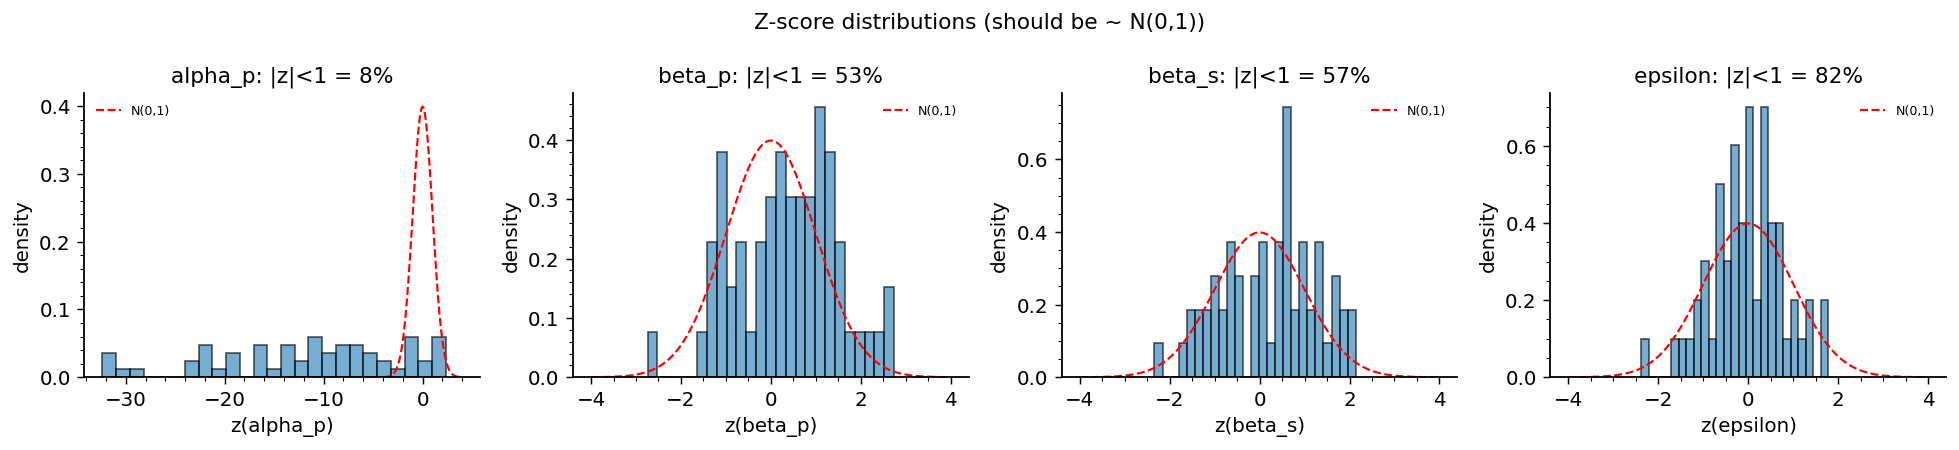

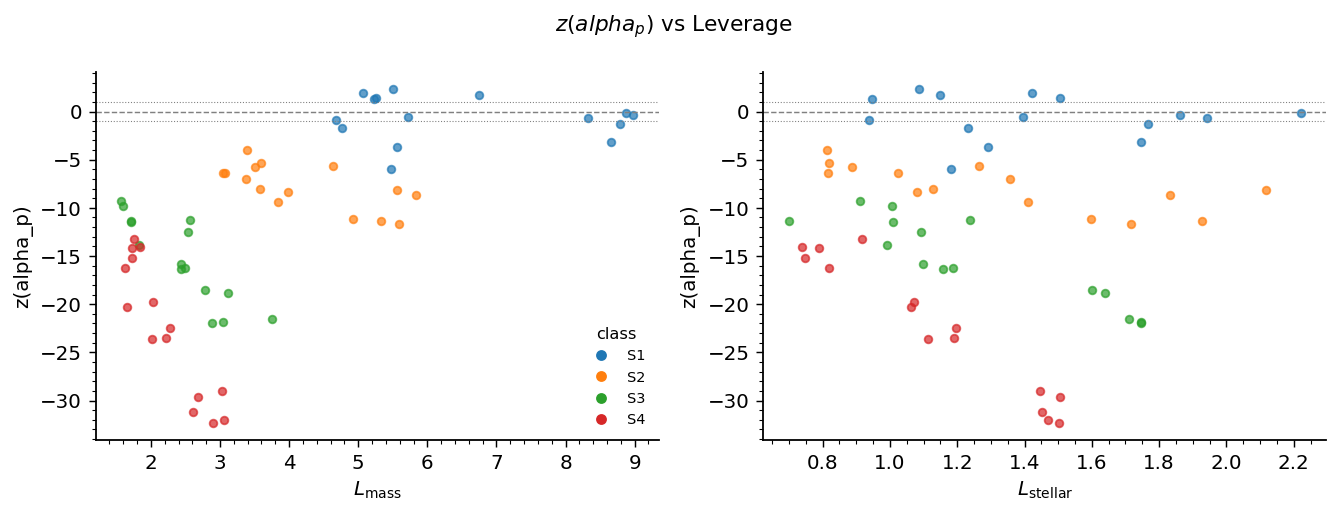

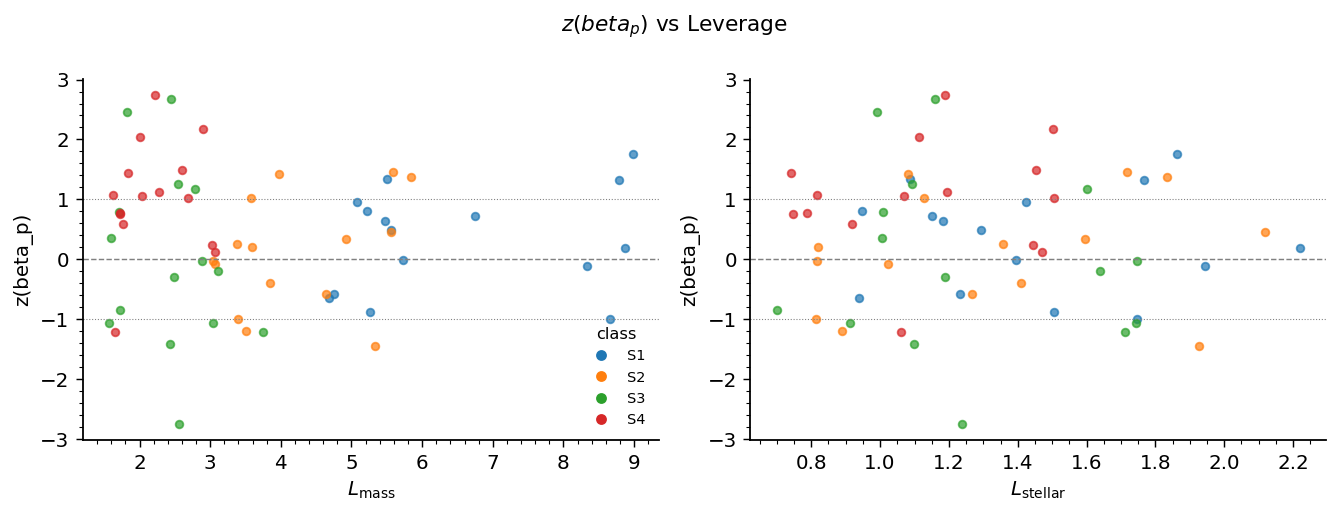

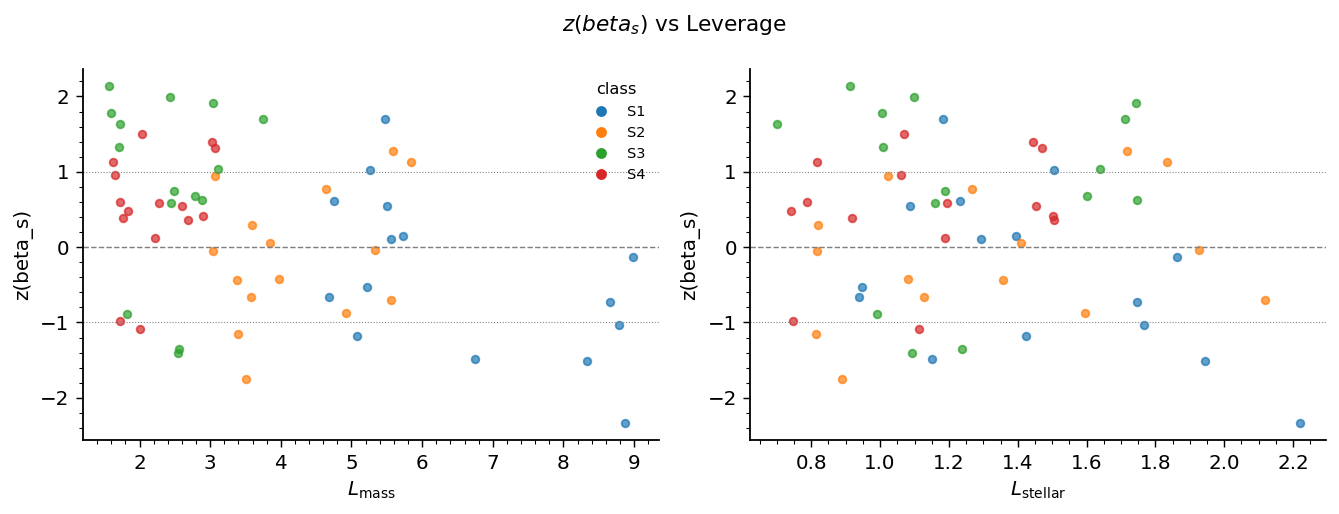

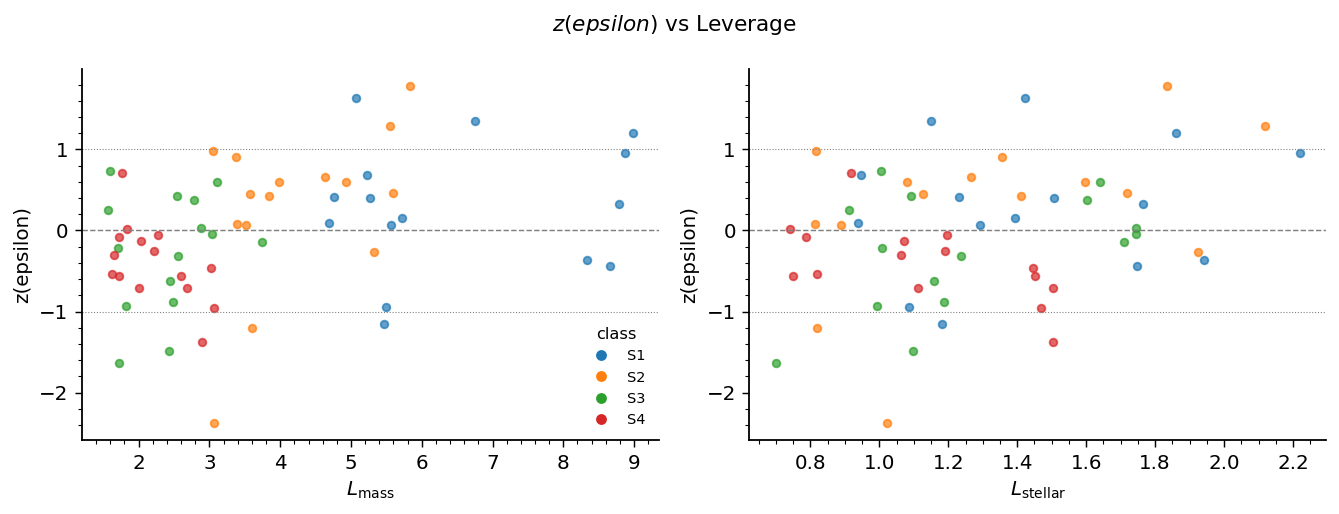

In [16]:
# Z-score histograms and Z vs leverage
df_z = df_results[(df_results['model'] == PRIMARY) &
                  (df_results['seed'] == MCMC_SEEDS[0])].copy()
z_params = [p for p in ['alpha_p','beta_p','beta_s','epsilon'] if f'z_{p}' in df_z.columns]

# --- Histograms ---
n_par = len(z_params)
fig, axes = plt.subplots(1, n_par, figsize=(3.8*n_par, 3.5))
if n_par == 1:
    axes = [axes]
fig.suptitle('Z-score distributions (should be ~ N(0,1))', fontsize=12)
xgrid = np.linspace(-4, 4, 200)
gauss = np.exp(-0.5*xgrid**2) / np.sqrt(2*np.pi)
for ax, p in zip(axes, z_params):
    vals = df_z[f'z_{p}'].dropna()
    ax.hist(vals, bins=25, density=True, alpha=0.6, edgecolor='k', lw=0.5)
    ax.plot(xgrid, gauss, 'r--', lw=1.2, label='N(0,1)')
    ax.set_xlabel(f'z({p})')
    ax.set_ylabel('density')
    ax.set_title(f'{p}: |z|<1 = {(np.abs(vals)<1).mean():.0%}')
    ax.legend(fontsize=7, frameon=False)
    ax.minorticks_on()
fig.tight_layout()
plt.show()

# --- Z vs L_mass and L_stellar ---
for p in z_params:
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
    fig.suptitle(rf'$z({p})$ vs Leverage', fontsize=12)
    for ax, Lcol, Llab in [(axes[0], 'L_mass', r'$L_{\mathrm{mass}}$'),
                            (axes[1], 'L_stellar', r'$L_{\mathrm{stellar}}$')]:
        for cls in CLS_ORD:
            cm = df_z['class_label'] == cls
            if not cm.any():
                continue
            ax.scatter(df_z.loc[cm, Lcol], df_z.loc[cm, f'z_{p}'],
                       s=18, alpha=0.7, color=CLS_CLR.get(cls,'k'), label=cls)
        ax.axhline(0, color='grey', ls='--', lw=0.8)
        ax.axhline(1, color='grey', ls=':', lw=0.6)
        ax.axhline(-1, color='grey', ls=':', lw=0.6)
        ax.set_xlabel(Llab)
        ax.set_ylabel(f'z({p})')
        ax.minorticks_on()
    add_legend(axes[0], df_z)
    fig.tight_layout()
    plt.show()

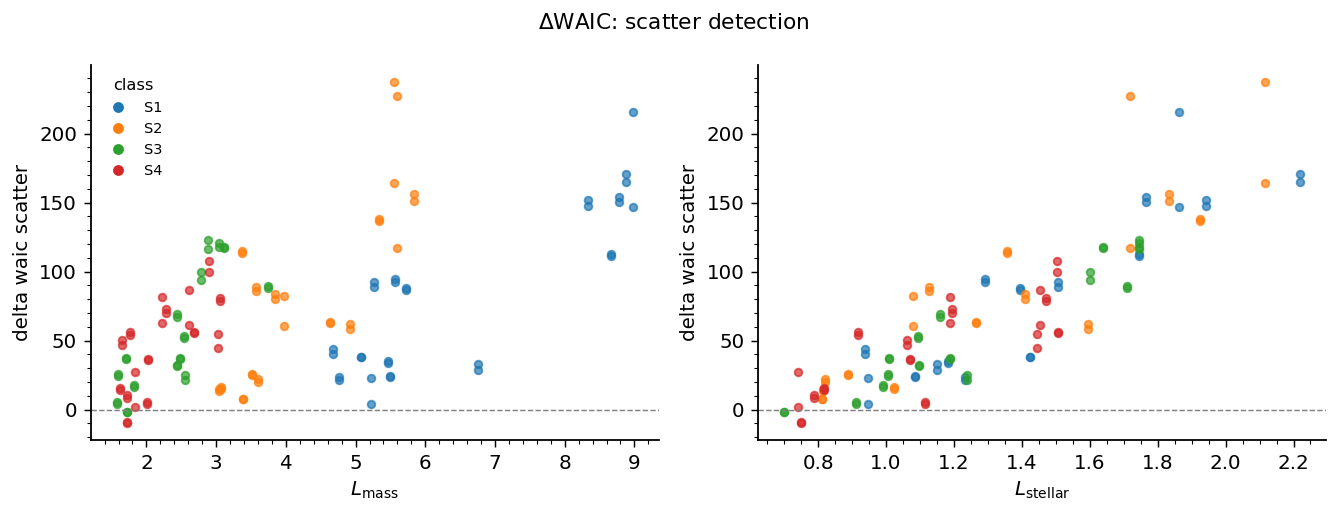

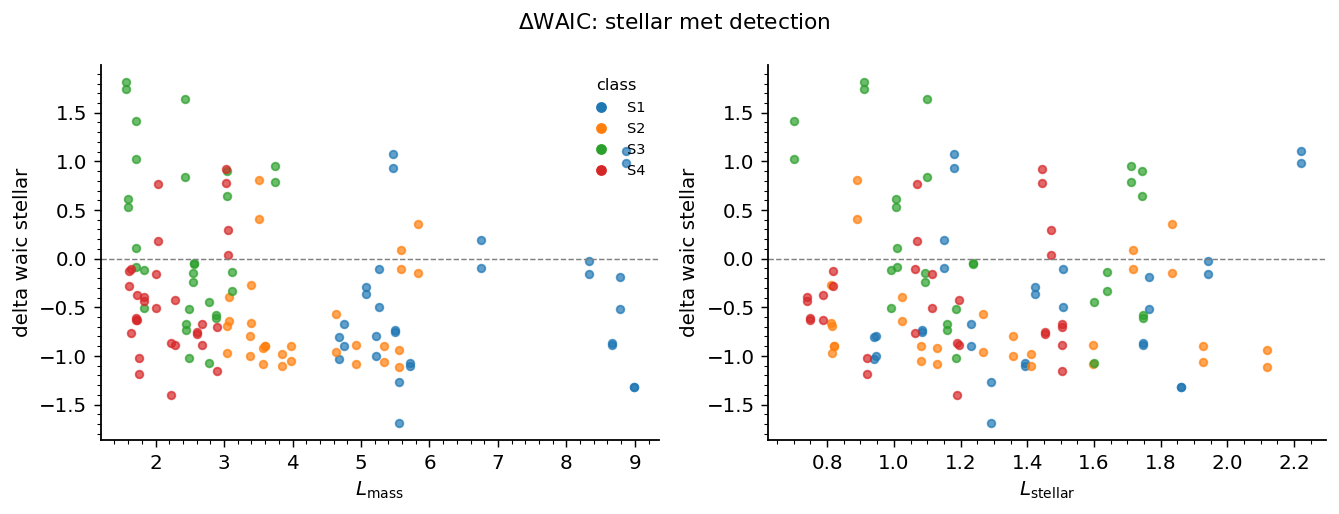

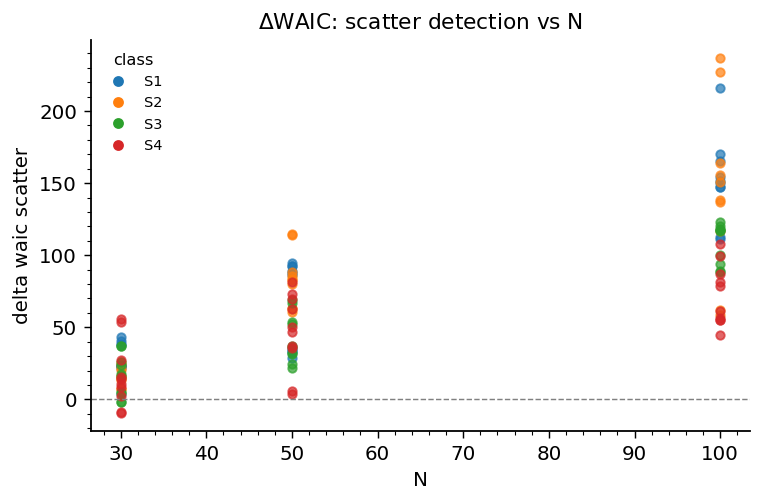

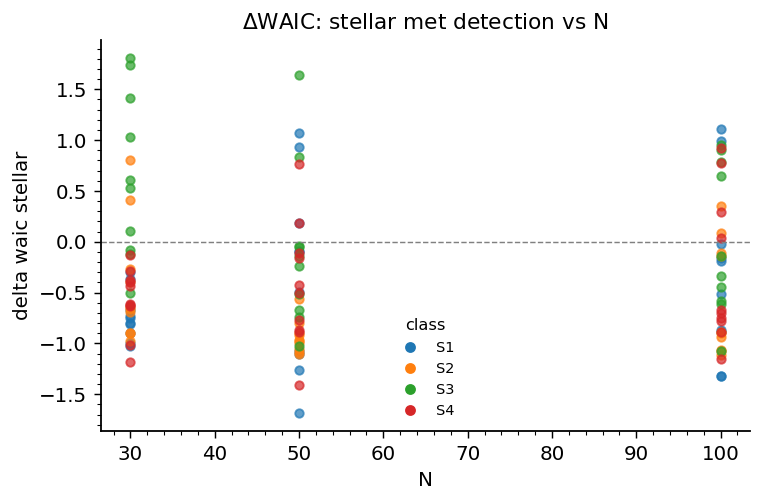

In [17]:
if waic_wide is not None:
    delta_cols = [c for c in ['delta_waic_scatter','delta_waic_stellar'] if c in waic_wide.columns]
    titles = {'delta_waic_scatter': r'$\Delta$WAIC: scatter detection',
              'delta_waic_stellar': r'$\Delta$WAIC: stellar met detection'}

    # vs L_mass and L_stellar
    for dc in delta_cols:
        fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
        fig.suptitle(titles.get(dc, dc), fontsize=12)
        labels = waic_wide['class_label'].to_numpy(str)
        for ax, Lcol, Llab in [(axes[0], 'L_mass', r'$L_{\mathrm{mass}}$'),
                                (axes[1], 'L_stellar', r'$L_{\mathrm{stellar}}$')]:
            vals = waic_wide[dc].values
            Lv = waic_wide[Lcol].values
            for cls in CLS_ORD:
                cm = labels == cls
                if not cm.any():
                    continue
                ax.scatter(Lv[cm], vals[cm], s=18, alpha=0.7,
                           color=CLS_CLR.get(cls,'k'), label=cls)
            ax.axhline(0, color='grey', ls='--', lw=0.8)
            ax.set_xlabel(Llab)
            ax.set_ylabel(dc.replace('_',' '))
            ax.minorticks_on()
        add_legend(axes[0], waic_wide)
        fig.tight_layout()
        plt.show()

    # vs N
    for dc in delta_cols:
        fig, ax = plt.subplots(figsize=(6, 4))
        labels = waic_wide['class_label'].to_numpy(str)
        for cls in CLS_ORD:
            cm = labels == cls
            if not cm.any():
                continue
            ax.scatter(waic_wide.loc[cm, 'N'], waic_wide.loc[cm, dc],
                       s=22, alpha=0.7, color=CLS_CLR.get(cls,'k'), label=cls)
        ax.axhline(0, color='grey', ls='--', lw=0.8)
        ax.set_xlabel('N')
        ax.set_ylabel(dc.replace('_',' '))
        ax.set_title(titles.get(dc, dc) + ' vs N')
        ax.minorticks_on()
        add_legend(ax, waic_wide)
        fig.tight_layout()
        plt.show()
else:
    print('WAIC not computed -- skipping plots.')

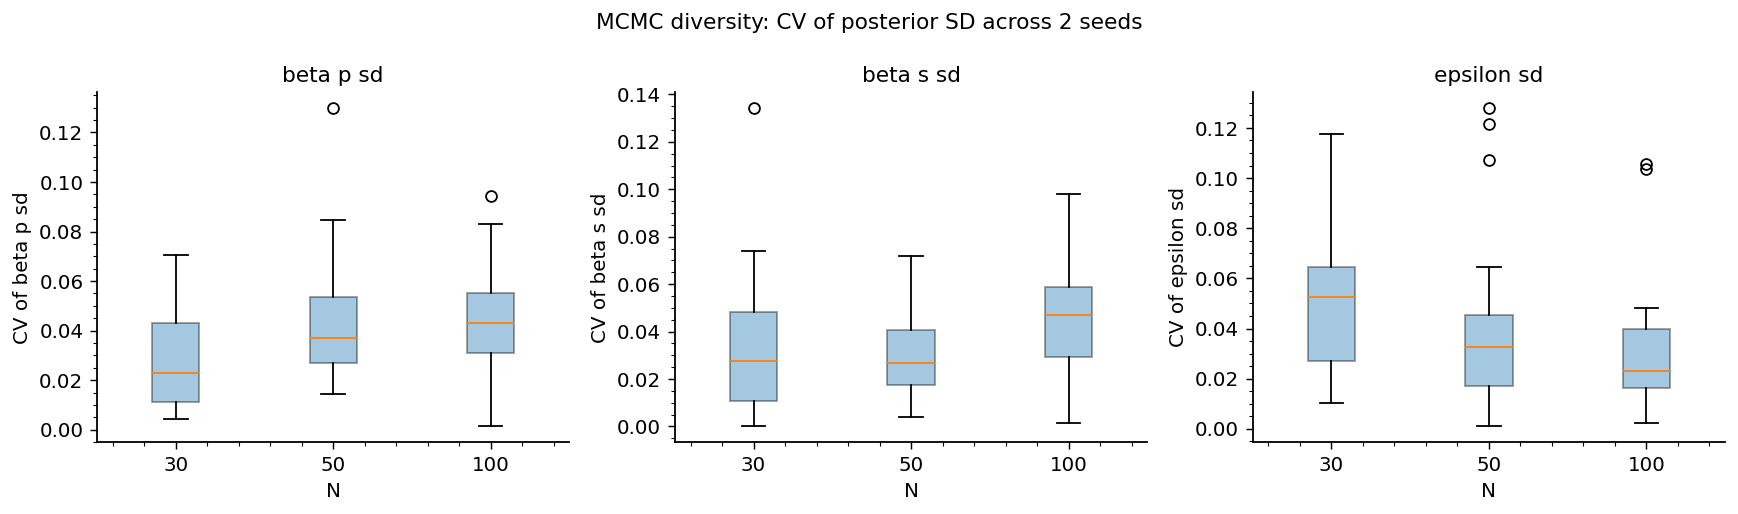

In [18]:
# Multi-seed diversity: how much do posteriors change across MCMC seeds?
if len(MCMC_SEEDS) > 1:
    df_div = df_results[df_results['model'] == PRIMARY].copy()
    params = [p for p in ['beta_p_sd','beta_s_sd','epsilon_sd'] if p in df_div.columns]

    # For each survey, compute the CV of sigma across seeds
    grouped = df_div.groupby('survey_id')
    div_rows = []
    for sid, grp in grouped:
        row = {'survey_id': sid, 'N': grp['N'].iloc[0],
               'class_label': grp['class_label'].iloc[0],
               'L_mass': grp['L_mass'].iloc[0],
               'L_stellar': grp['L_stellar'].iloc[0]}
        for p in params:
            vals = grp[p].dropna()
            if len(vals) > 1:
                row[f'{p}_cv'] = float(vals.std() / vals.mean()) if vals.mean() > 0 else np.nan
        div_rows.append(row)
    df_div_summary = pd.DataFrame(div_rows)

    # Box plot of CV by N
    cv_cols = [c for c in df_div_summary.columns if c.endswith('_cv')]
    if cv_cols:
        fig, axes = plt.subplots(1, len(cv_cols), figsize=(4.5*len(cv_cols), 4))
        if len(cv_cols) == 1:
            axes = [axes]
        fig.suptitle(f'MCMC diversity: CV of posterior SD across {len(MCMC_SEEDS)} seeds', fontsize=12)
        for ax, col in zip(axes, cv_cols):
            data = [df_div_summary.loc[df_div_summary['N']==N0, col].dropna()
                    for N0 in sorted(df_div_summary['N'].unique())]
            bp = ax.boxplot(data, labels=[str(n) for n in sorted(df_div_summary['N'].unique())],
                           patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor('C0')
                patch.set_alpha(0.4)
            ax.set_xlabel('N')
            pname = col.replace('_cv','').replace('_',' ')
            ax.set_ylabel(f'CV of {pname}')
            ax.set_title(pname)
            ax.minorticks_on()
        fig.tight_layout()
        plt.show()
else:
    print('Only 1 seed -- skipping diversity analysis.')

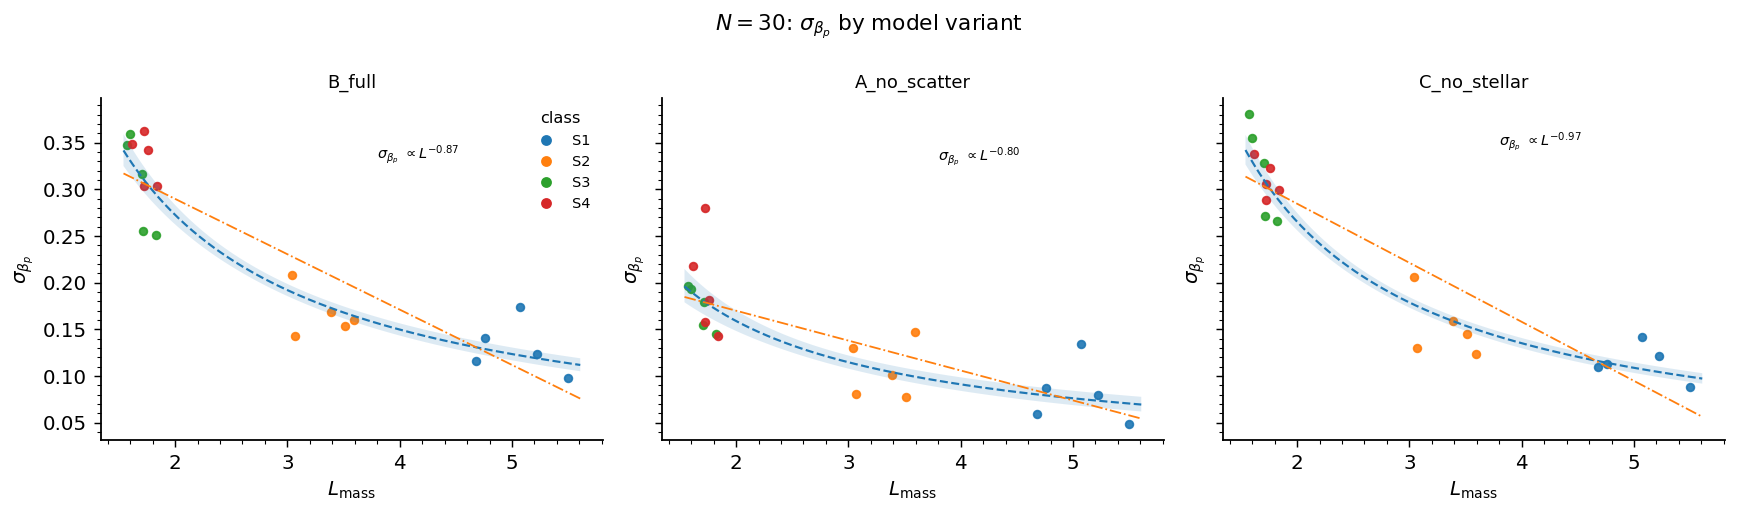

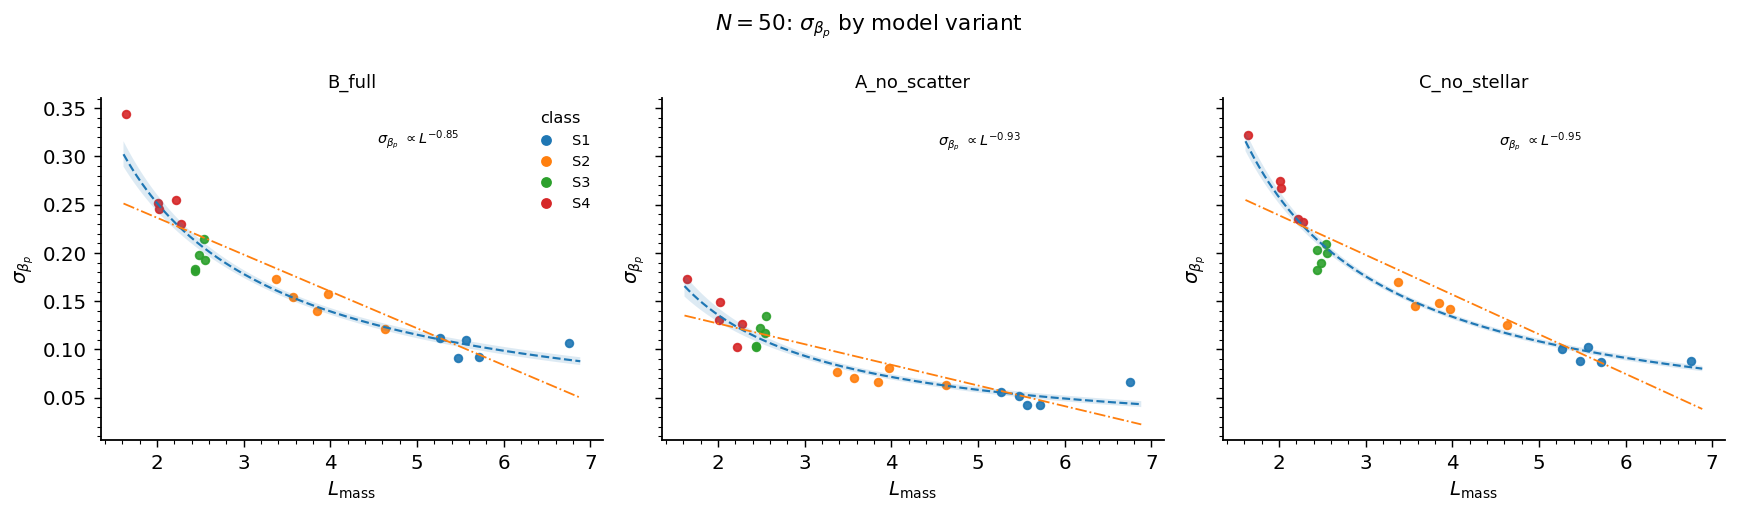

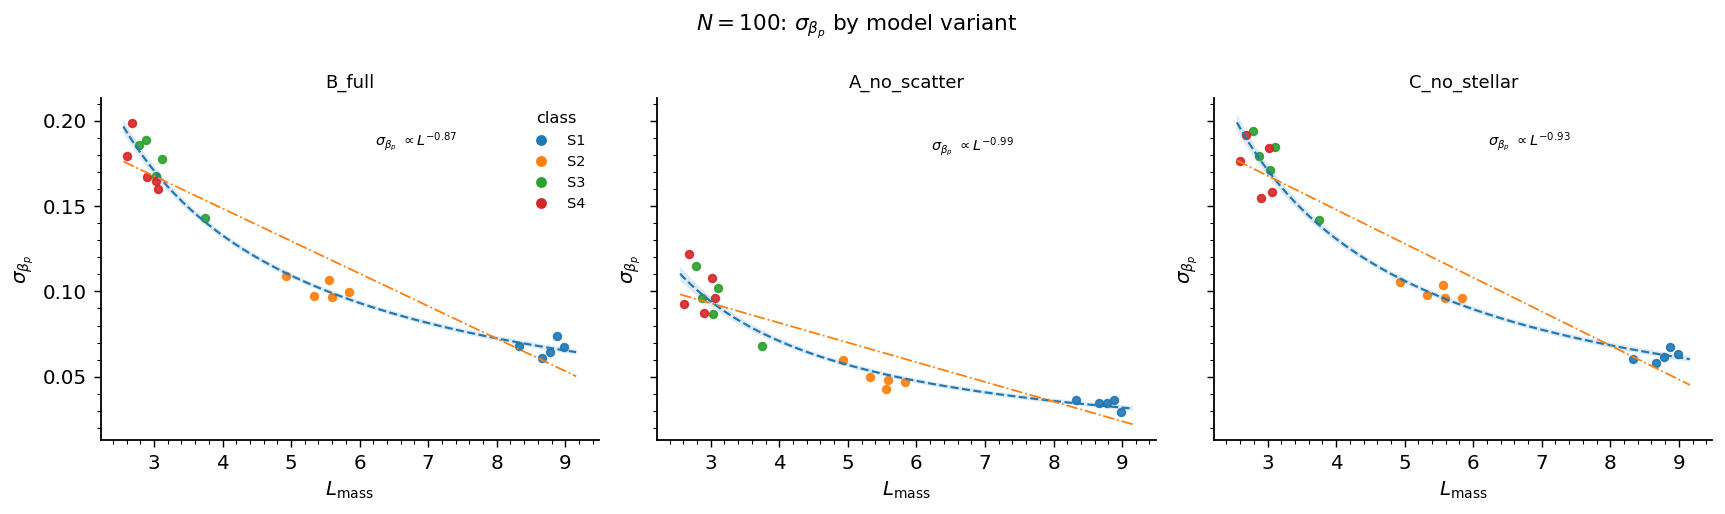

In [19]:
# Compare sigma(beta_p) across model variants (scatter toggle effect)
seed0 = MCMC_SEEDS[0]
model_names = df_results['model'].unique()
n_models = len(model_names)

for N0 in sorted(df_results['N'].unique()):
    sub = df_results[(df_results['N'] == N0) & (df_results['seed'] == seed0)]
    if len(sub) < 3:
        continue

    fig, axes = plt.subplots(1, n_models, figsize=(4.5*n_models, 4), sharey=True)
    if n_models == 1:
        axes = [axes]
    fig.suptitle(rf'$N={N0}$: $\sigma_{{\beta_p}}$ by model variant', fontsize=12)

    for ax, mn in zip(axes, model_names):
        msub = sub[sub['model'] == mn]
        if msub.empty:
            ax.set_title(mn)
            continue
        labels = msub['class_label'].to_numpy(str)
        scatter_fits(ax, msub['L_mass'].values, msub['beta_p_sd'].values,
                     labels, r'$\sigma_{\beta_p}$', r'$L_{\mathrm{mass}}$')
        ax.set_title(mn, fontsize=10)
    add_legend(axes[0], sub)
    fig.tight_layout()
    plt.show()

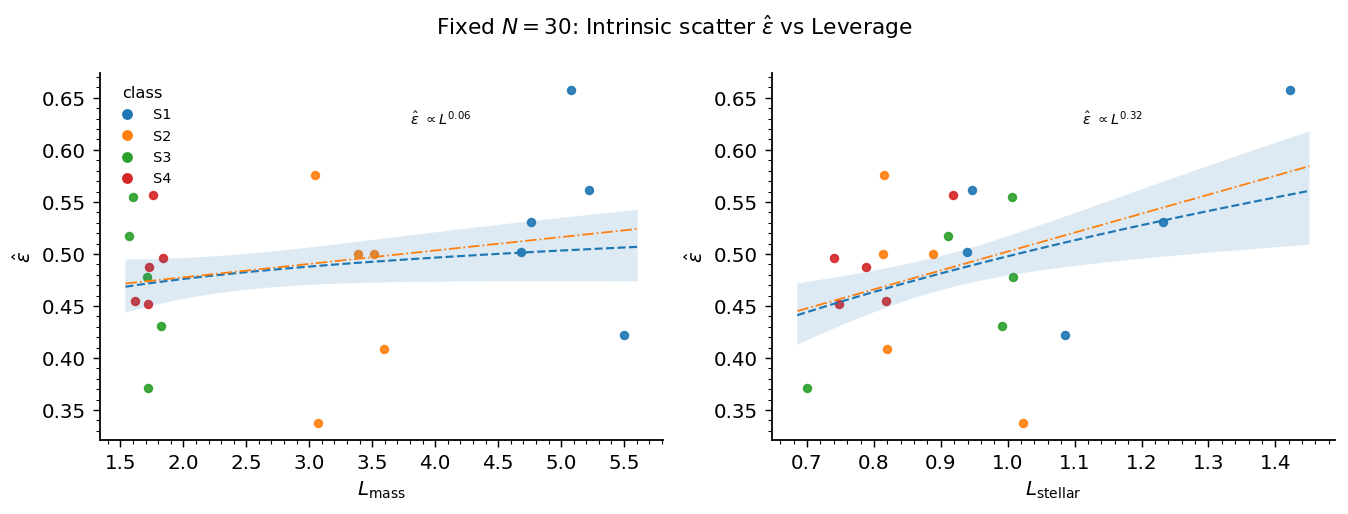

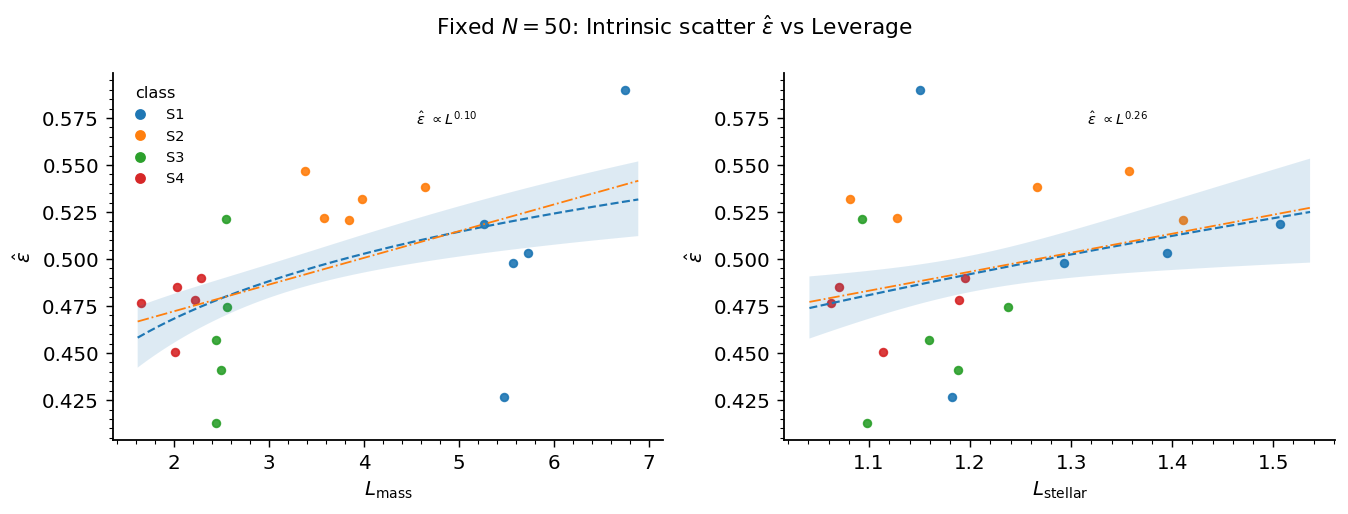

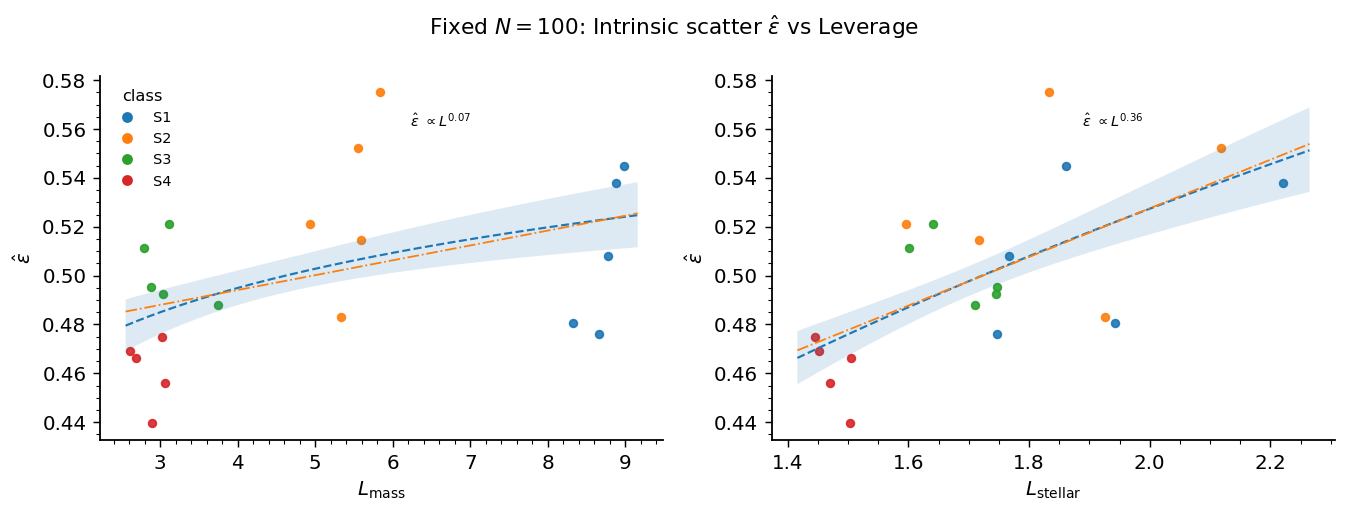

In [20]:
# Posterior mean intrinsic scatter vs leverage (matching HERMES scatter plot)
df_sc = df_results[(df_results['model'] == PRIMARY) &
                   (df_results['seed'] == MCMC_SEEDS[0])].copy()

if 'epsilon_mean' in df_sc.columns:
    for N0 in sorted(df_sc['N'].unique()):
        sub = df_sc[df_sc['N'] == N0]
        if len(sub) < 3:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(10.5, 4))
        fig.suptitle(rf'Fixed $N={N0}$: Intrinsic scatter $\hat\varepsilon$ vs Leverage',
                     fontsize=12)
        labels = sub['class_label'].to_numpy(str)
        scatter_fits(axes[0], sub['L_mass'].values, sub['epsilon_mean'].values,
                     labels, r'$\hat{\varepsilon}$', r'$L_{\mathrm{mass}}$')
        scatter_fits(axes[1], sub['L_stellar'].values, sub['epsilon_mean'].values,
                     labels, r'$\hat{\varepsilon}$', r'$L_{\mathrm{stellar}}$')
        add_legend(axes[0], sub)
        fig.tight_layout()
        plt.show()
else:
    print('No epsilon_mean column (scatter may be off).')